In [1]:
import os
import sys

import torch
import torch.nn as nn
import numpy as np
import pylab as plt
os.makedirs('./synthetic_images/', exist_ok=True)


# Disable
def disable_print():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enable_print():
    sys.stdout = sys.__stdout__

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best possible Acc: 75.0


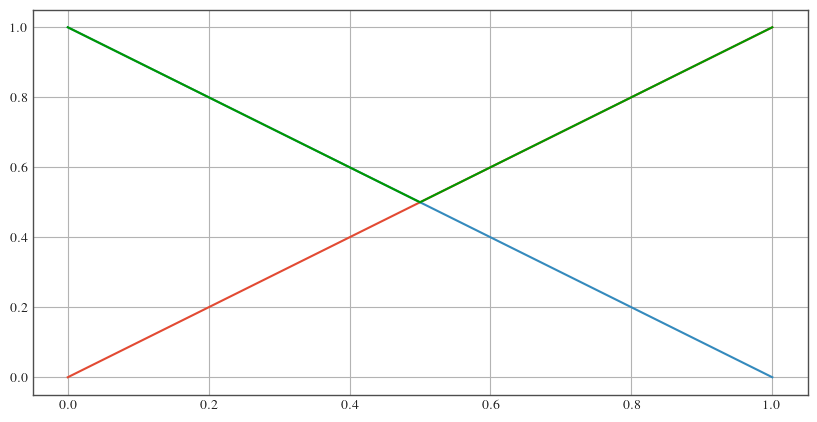

In [2]:
f = lambda x: np.exp(5*x) / np.exp(5)
f = lambda x: x
# f = lambda x: x

rel_px = np.linspace(0, 1, 101)
plt.plot(rel_px, f(rel_px))
plt.plot(rel_px, 1-f(rel_px))
gt_f = lambda x: np.max(np.stack((f(x), 1-f(x))), axis=0)
plt.plot(rel_px, gt_f(rel_px))
print('Best possible Acc:', np.trapz(gt_f(rel_px)))

In [9]:
torch.manual_seed(0)
all_imgs = []
all_labels = []

# Create a dataset in which the sum of pixels corresponds to the true probability of the label = 1
img_shape = (3, 32, 32)
n_pixel = np.prod(img_shape)
n_sampler_per_percent = 100
for i in range(101):
    proba_class1 = f(float(i) / 100)
    # proba_class1 = float(i) / 100
    labels = torch.empty(n_sampler_per_percent).bernoulli_(p=proba_class1).long()
    imgs = torch.zeros(n_sampler_per_percent, n_pixel).float()

    for i in range(len(imgs)):
        # randomly set (proba_class1*n_pixel) pixels of an image to one
        indices = torch.randperm(n_pixel)[:int(proba_class1*n_pixel)]
        imgs[i, indices] = 1

    imgs = imgs.view(len(imgs), *img_shape)
    all_imgs.append(imgs)
    all_labels.append(labels)

instances = torch.cat(all_imgs)
labels = torch.cat(all_labels)

torch.save({'instances': instances, 'labels': labels}, './synthetic_images/pixel_sum_dataset.pth')
dataset = torch.utils.data.TensorDataset(instances, labels)


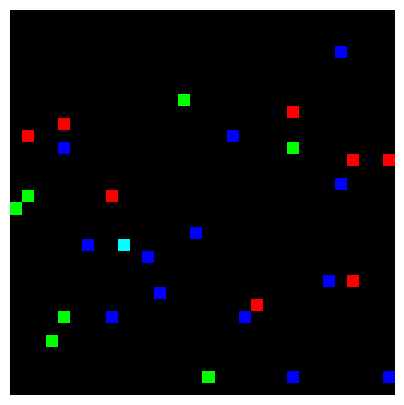

10100


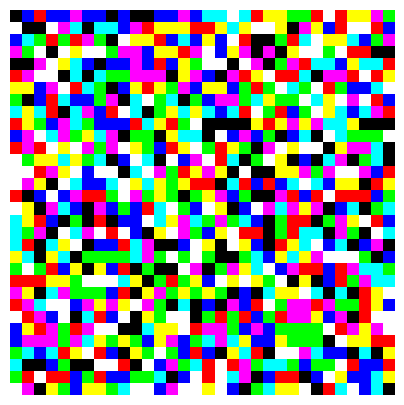

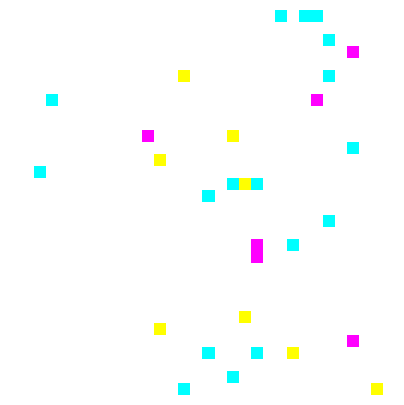

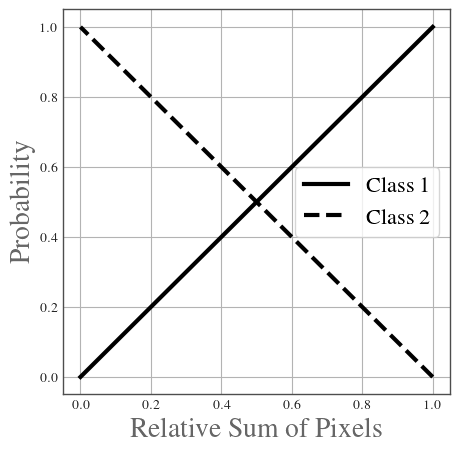

In [10]:
plt.figure(figsize=(5, 5))
print(len(dataset))

img = instances[100]
proba = (img.mean().item())
plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/low_proba_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
img = instances[5000]
proba = (img.mean().item())
plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/aleatoric_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
img = instances[-101]
proba = (img.mean().item())
plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/high_proba_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], linewidth=3, color='k', label='Class 1')
plt.plot([1, 0], [0, 1], linewidth=3, color='k', linestyle='--', label='Class 2')
plt.xlabel('Relative Sum of Pixels', fontdict={'fontsize': 20})
plt.ylabel('Probability', fontdict={'fontsize': 20})
plt.legend(**{'fontsize': 16})
plt.savefig('./synthetic_images/ds_info.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.7361 (0.7361) acc1: 56.6667 (56.6667) time: 0.8912 data: 0.0005 max mem: 211
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.2559 (0.2559) acc1: 100.0000 (100.0000) time: 0.0216 data: 0.0003 max mem: 286
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.0923 (0.0923) acc1: 100.0000 (100.0000) time: 0.0216 data: 0.0004 max mem: 286
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.0434 (0.0434) acc1: 100.0000 (100.0000) time: 0.0214 data: 0.0003 max mem: 286
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.0239 (0.0239) acc1: 100.0000 (100.0000) time: 0.0213 data: 0.0003 max mem: 286
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.0143 (0.0143) acc1: 100.0000 (100.0000) time: 0.0214 data: 0.0004 max mem: 286
Epoch [5] Total time: 0:00:00
Epoch [6] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.0088 (0.0088) acc1: 100.00

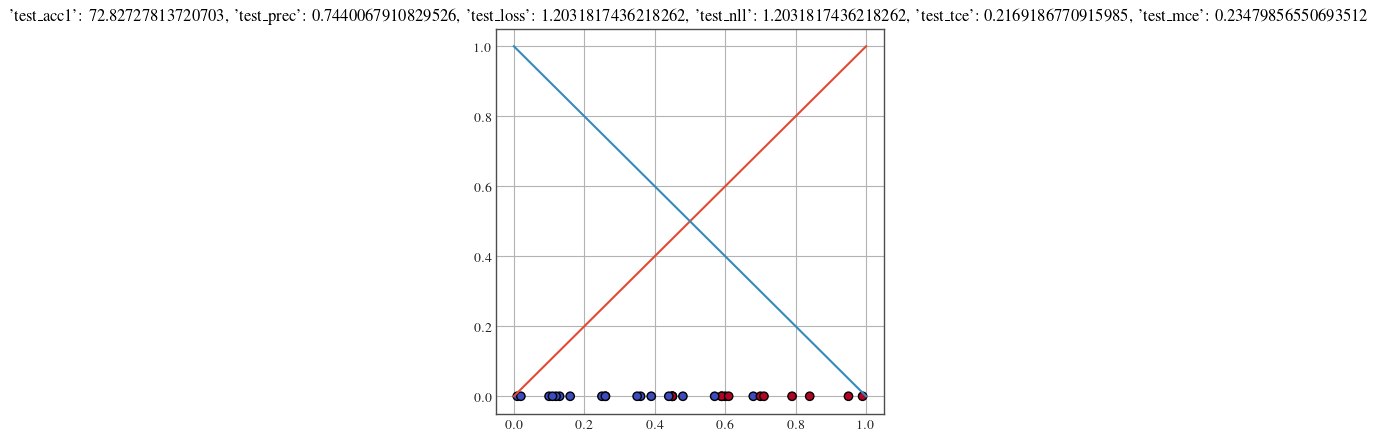

In [5]:
from dal_toolbox.models.deterministic.resnet import ResNet18
from dal_toolbox.models.deterministic.train import train_one_epoch
from dal_toolbox.models.deterministic.evaluate import evaluate
from dal_toolbox.utils import seed_everything

seed_everything(0)

rnd_indices = np.random.permutation(len(dataset))
train_ds = torch.utils.data.Subset(dataset, indices=rnd_indices[:30])
test_ds = torch.utils.data.Subset(dataset, indices=rnd_indices[int(len(dataset)*.1):])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

model = ResNet18(num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=.9, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(100):
    train_stats = train_one_epoch(model, train_loader, criterion, optimizer, epoch=i, device='cuda')
test_stats = evaluate(model, test_loader, {}, criterion, device='cuda')

# Plot Samples
probs, labels = [], []
for x, y in train_ds:
    probs.append(x.mean())
    labels.append(y)
probs = torch.stack(probs)
labels = torch.stack(labels)

plt.figure(figsize=(5, 5))
rel_px = np.linspace(0, 1, 101)
plt.title(test_stats)
plt.plot(rel_px, f(rel_px))
plt.plot(rel_px, 1-f(rel_px))
plt.scatter(probs, torch.zeros_like(probs), c=labels)
plt.show()

## Active Learning

Using train_dataset for queries. Make sure that there are no augmentations used.


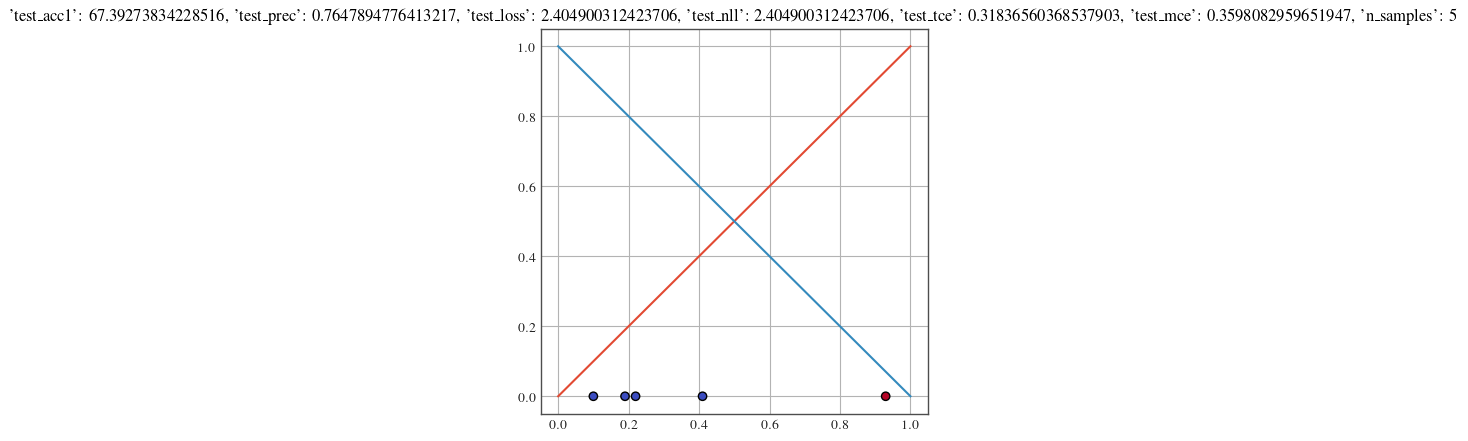

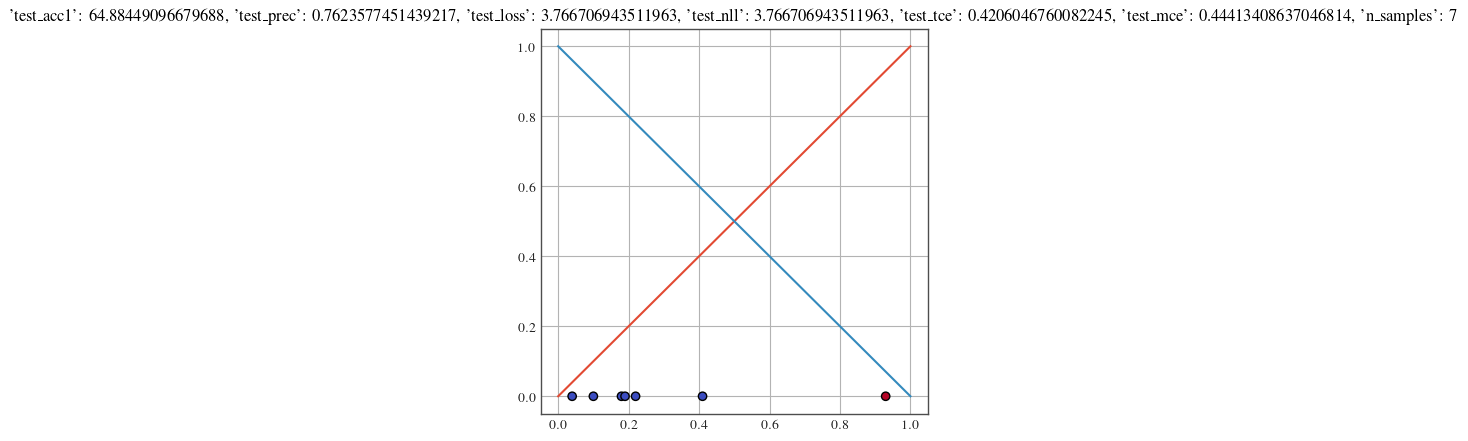

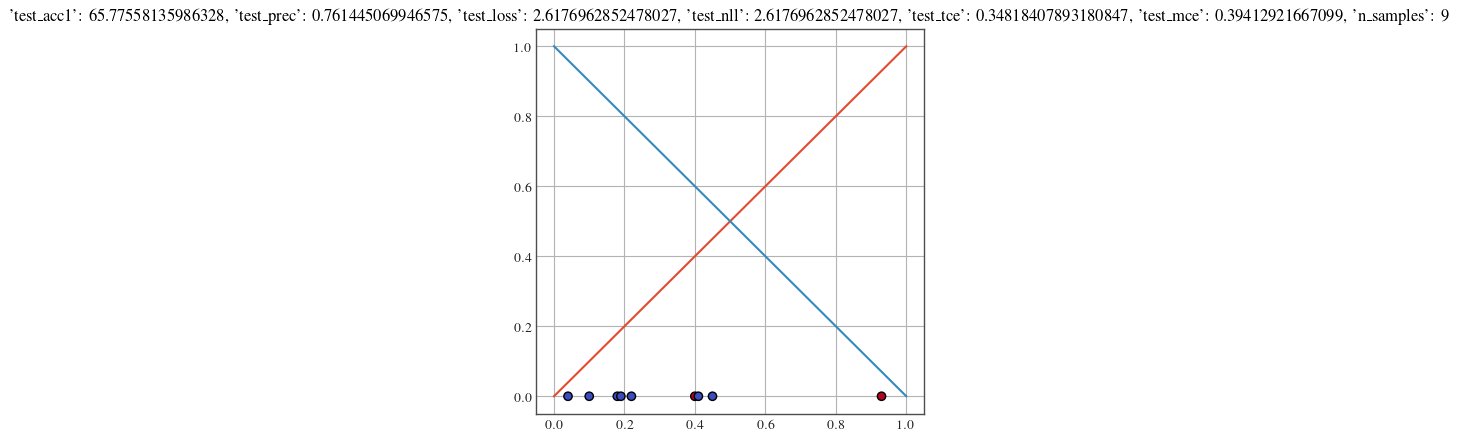

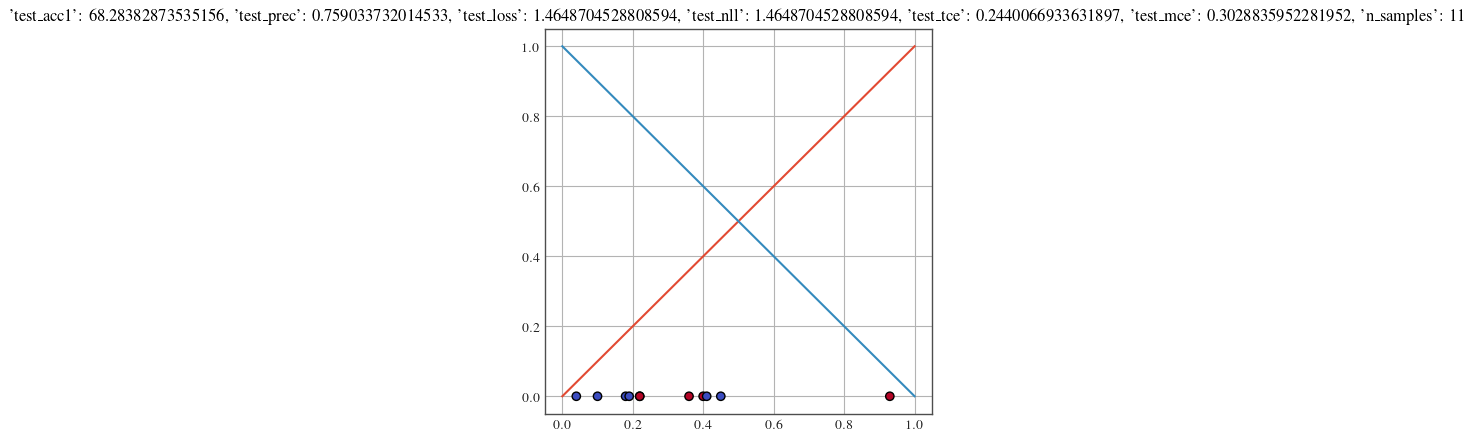

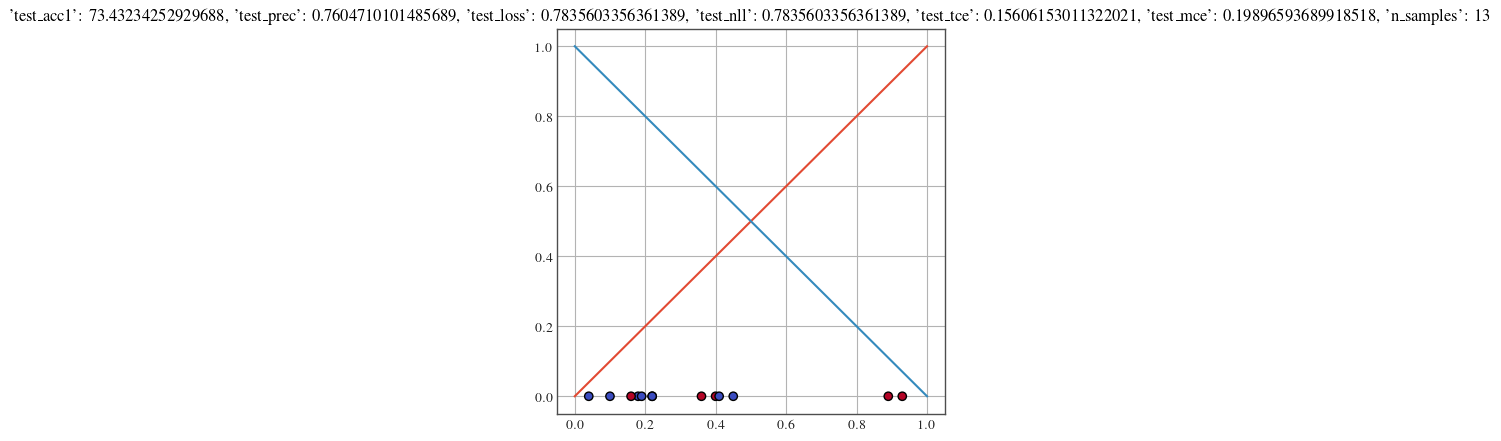

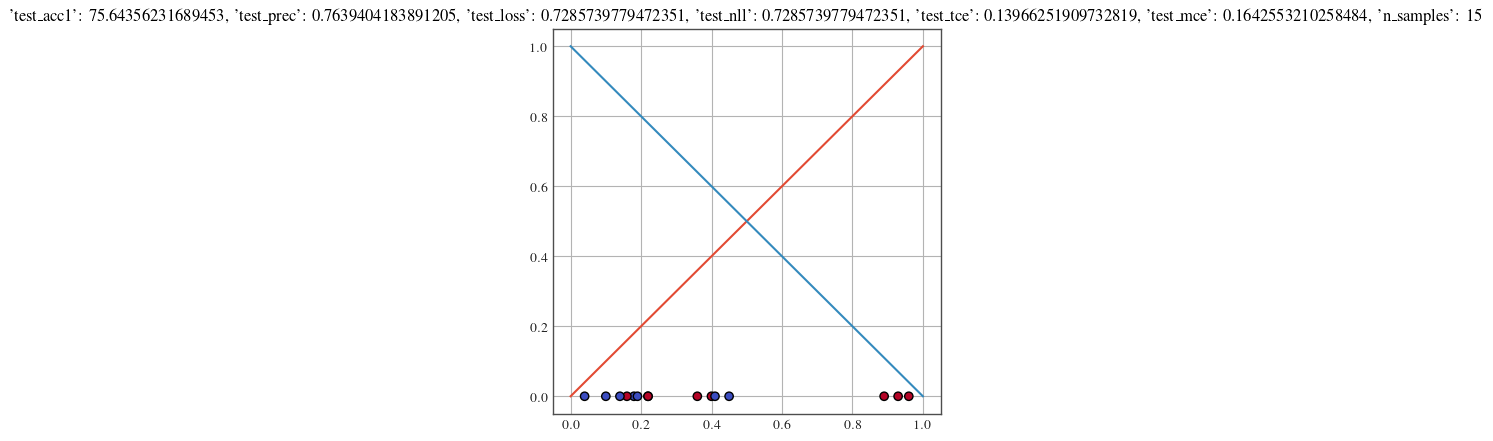

In [6]:
from copy import deepcopy
from torch.utils.data import Subset, RandomSampler, DataLoader

from dal_toolbox.active_learning.data import ALDataset
from dal_toolbox.active_learning.strategies import random, uncertainty
from dal_toolbox.models.deterministic.resnet import ResNet18
from dal_toolbox.models.deterministic.train import train_one_epoch
from dal_toolbox.models.deterministic.evaluate import evaluate
from dal_toolbox.utils import seed_everything


seed_everything(42)
rnd_indices = np.random.permutation(len(dataset))
n_train_samples = int(len(dataset)*.7)
train_ds = Subset(dataset, indices=rnd_indices[:n_train_samples])
test_ds = Subset(dataset, indices=rnd_indices[n_train_samples:])

hparams = dict(
    n_epochs=100,
    lr=1e-2,
    momentum=.9,
    weight_decay=0.005,
    batch_size=128,
    n_cycles=5,
    n_init=5,
    acq_size=2,
)

# Setup Model
model = ResNet18(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=hparams['lr'], 
    momentum=hparams['momentum'], 
    weight_decay=hparams['weight_decay']
)

al_dataset = ALDataset(dataset, random_state=1)
al_dataset.random_init(hparams['n_init'])
al_strat = random.RandomSampling()

init_model_state = deepcopy(model.state_dict())
init_optimizer_state = deepcopy(optimizer.state_dict())

results = []
for i_cycle in range(hparams['n_cycles']+1):
    if i_cycle != 0:
        indices = al_strat.query(al_dataset.unlabeled_indices, acq_size=hparams['acq_size'])
        al_dataset.update_annotations(indices)

    model.load_state_dict(init_model_state)
    optimizer.load_state_dict(init_optimizer_state)

    # Training
    labeled_ds = al_dataset.labeled_dataset
    iter_per_epoch = (len(labeled_ds) // hparams['batch_size']) + 1
    sampler = RandomSampler(labeled_ds, num_samples=(iter_per_epoch*hparams['batch_size']))
    train_loader = DataLoader(labeled_ds, batch_size=hparams['batch_size'], sampler=sampler)
    
    disable_print()
    train_history = []
    for i in range(hparams['n_epochs']):
        train_stats = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda', epoch=i)
        train_history.append(train_stats)
    enable_print()

    # Testing
    test_loader = DataLoader(test_ds, batch_size=hparams['batch_size']*4)
    test_stats = evaluate(model, test_loader, criterion=criterion,  dataloaders_ood={}, device='cuda')
    test_stats['n_samples'] = len(labeled_ds)
    results.append(test_stats)

    # Plot Samples
    probs, labels = [], []
    for x, y in labeled_ds:
        probs.append(x.mean())
        labels.append(y)
    probs = torch.stack(probs)
    labels = torch.stack(labels)

    plt.figure(figsize=(5, 5))
    rel_px = np.linspace(0, 1, 101)
    plt.title(test_stats)
    plt.plot(rel_px, f(rel_px))
    plt.plot(rel_px, 1-f(rel_px))
    plt.scatter(probs, torch.zeros_like(probs), c=labels)
    plt.show()


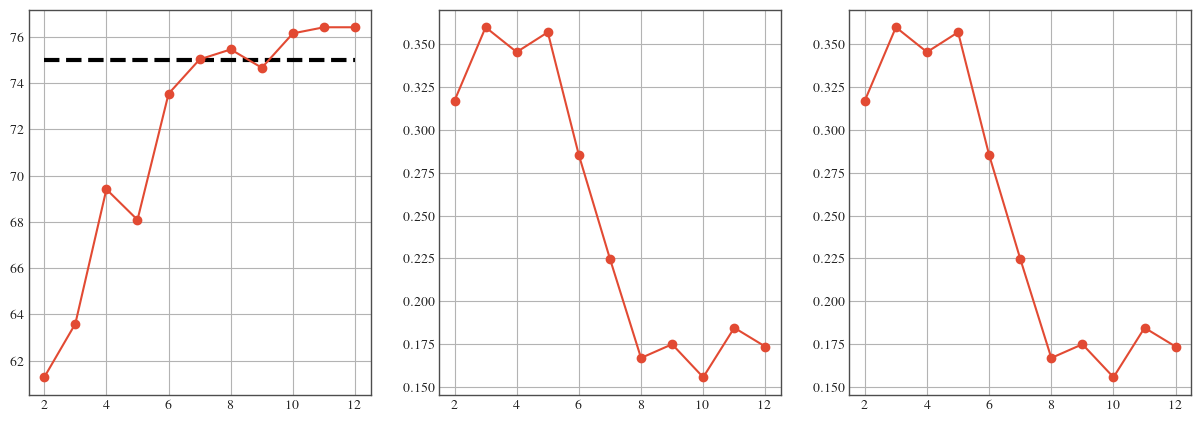

In [327]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
# plt.figure(figsize=(5, 5))
plt.hlines(75, 2, 12, colors='k', linestyles='--', linewidth=3)
plt.plot([d['n_samples'] for d in results], [d['test_acc1'] for d in results], '-o')
# plt.figure(figsize=(5, 5))
plt.subplot(132)
plt.plot([d['n_samples'] for d in results], [d['test_tce'] for d in results], '-o')
plt.subplot(133)
# plt.figure(figsize=(5, 5))
plt.plot([d['n_samples'] for d in results], [d['test_tce'] for d in results], '-o')
plt.show()

tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0.,   64.,  136.,  184.,
         164.,  217.,  260.,  439., 8418.])

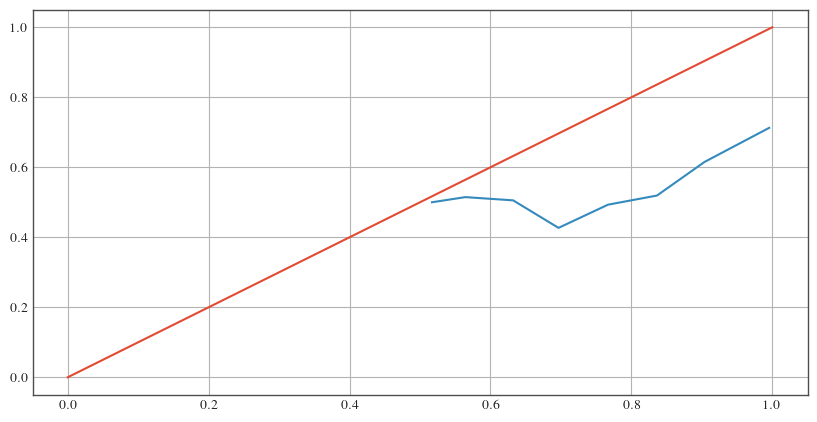

In [68]:
from dal_toolbox.metrics.calibration import TopLabelCalibrationError

def get_logits_and_labels(model, dataloader, device='cuda'):
    model.cuda()
    all_logits, all_targets = [], []
    for inputs, targets in dataloader:
        with torch.no_grad():
            logits = model(inputs.cuda())
        all_logits.append(logits.cpu())
        all_targets.append(targets)
    logits = torch.cat(all_logits)
    targets = torch.cat(all_targets)
    return logits, targets

logits, targets = get_logits_and_labels(model, test_loader)
tce_criterion = TopLabelCalibrationError()
tce_criterion.forward(logits.softmax(-1), targets)

plt.plot([0, 1], [0, 1])
plt.plot(tce_criterion.results['confs'], tce_criterion.results['accs'])
tce_criterion.results['n_samples']